In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support,  roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [14]:
df = pd.read_csv('/Users/kevinchew/Desktop/p4/P4---West-Nile-Virus/code/train_weather_weekly.csv')

### Preprocessing

In [15]:
df['Species'] = df['Species'].map({'CULEX PIPIENS/RESTUANS': 1,'CULEX PIPIENS': 2,'CULEX RESTUANS': 3,
                                  'CULEX TERRITANS' : 4, 'CULEX SALINARIUS' : 5, 'CULEX TARSALIS' : 6,
                                  'CULEX ERRATICUS' : 7})

In [16]:
# Setting the variables
X = df[[col for col in df.columns if col not in ['Date', 'WnvPresent', 'Year-Week', 'Year_x']]]
y = df['WnvPresent']

## Modelling & Hyperparameter Tuning

In this section, we will run hyperparamter tuning for the models chosen. Then, since the data is heavily imbalanced, we will re-fit the model using the over-sampled data, which is obtained using SMOTE and obtain the train and test scores. 



In [17]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

### Baseline Prediction

In [18]:
# Look at the proportions of each outcome
y_train.value_counts(normalize=True)

0    0.940842
1    0.059158
Name: WnvPresent, dtype: float64

We observe that the data is heavily imbalanced. We will be ~94% accurate if we were to predict all to be the negative class (WNV not present). As such, we will be optimizing our models using AUC score instead of accuracy. We will also deploy SMOTE (Synthetic Minority Over-sampling Technique) to help us with over-sampling.

In [21]:
# Scaling
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [22]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [23]:
# Check proportions after SMOTE
ysm_train.value_counts()

0    5630
1    5630
Name: WnvPresent, dtype: int64

The over-sampled data will only be used when evaluating the train and test scores. When we are applying GridSearchCV to tune the hyperparameters, we will need to utilize an `imblearn.Pipeline` object to handle the samplers correctly.

## Fitting Logistic Regression

In [25]:
%%time
# This framework will be the one we use for our modelling
# We first work with a pipeline with Logistic Regression

print(f'Fitting Logistic Regression')      # Prints out what model that we are using 

# Set up pipeline
lr_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('lr', LogisticRegression(solver='newton-cg'))
    ])

# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
}

# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(lr_pipe, param_grid = lr_params, cv=5,
                     scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit
gs_lr.fit(Xs_train, y_train)


# See results
print(f'The best parameters are {gs_lr.best_estimator_}.')

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('lr', LogisticRegression(solver='newton-cg'))]).
CPU times: user 556 ms, sys: 98.5 ms, total: 654 ms
Wall time: 5.36 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [26]:
# Now we fit
lr = LogisticRegression(solver='newton-cg')
lr.fit(Xsm_train, ysm_train)

LogisticRegression(solver='newton-cg')

In [27]:
# Create list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []


model_name.append('Logistic Regression')
model_scores.append(lr.score(Xsm_train, ysm_train))
model_var.append(lr)
model_test_scores.append(lr.score(Xs_test,y_test))

### Evaluating Logistic Regression Results

In [28]:
importance = lr.coef_
features = X_train.columns
importance = importance.reshape(lr.coef_.shape[1],1)
imp_lr = pd.DataFrame(importance,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)
imp_lr

,weights
AvgSpeed_2,2.495271
NumMosquitos,2.050229
Tmin_2,1.714816
Tmax_2,1.671897
Week_x,1.661490
Week_y,1.661490
WetBulb_2,1.518317
PrecipTotal_2_shift14,1.317634
PrecipTotal_1,1.179041
Is Wnv Mosquitoes Types,1.141400


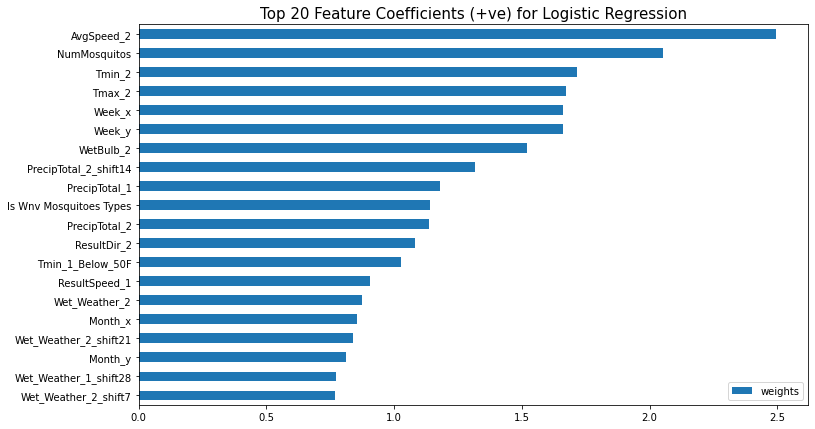

In [29]:
# Plotting top 20 +ve features in bar chart
imp_lr['weights'].head(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

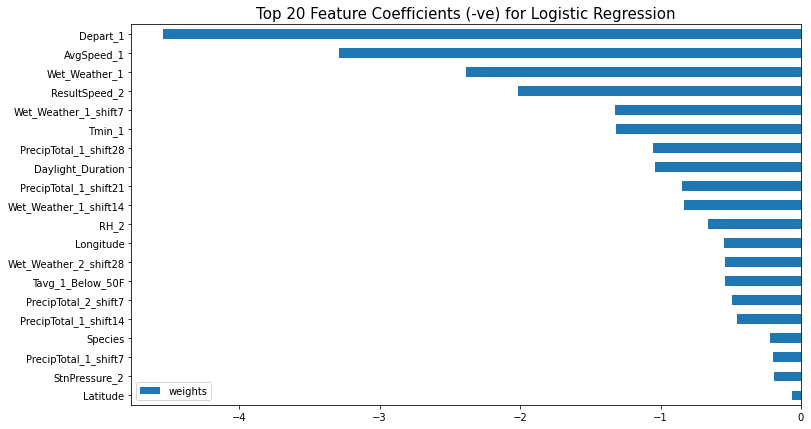

In [30]:
# Plotting top 20 -ve features in bar chart
imp_lr['weights'].tail(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.legend(loc=3);

## Fitting Naive Bayes

In [31]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting Naive Bayes')      # Prints out what model and vectorizer we are looking at

# Set up pipeline
nb_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('nb', BernoulliNB())
    ])

# Hyperparameters
nb_params = {
    'nb__alpha': [0.9, 1, 1.1]
}

# Instantiate 5-fold GridSearchCV.
gs_nb = GridSearchCV(nb_pipe, param_grid = nb_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_nb.fit(Xs_train, y_train)

# See results
print(f'The best parameters are {gs_nb.best_estimator_}.')

Fitting Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('nb', BernoulliNB(alpha=0.9))]).
CPU times: user 80 ms, sys: 18.4 ms, total: 98.4 ms
Wall time: 316 ms


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [32]:
nb = BernoulliNB(alpha=0.9)
nb.fit(Xsm_train, ysm_train)

BernoulliNB(alpha=0.9)

In [33]:
nb.score(Xsm_train,ysm_train)

0.7206927175843695

In [34]:
# Append to the lists
model_name.append('Naive Bayes')
model_scores.append(nb.score(Xsm_train, ysm_train))
model_var.append(nb)
model_test_scores.append(nb.score(Xs_test,y_test)) 

### Evaluating Naive Bayes Results

In [35]:
nb.feature_count_

array([[3139., 5384., 2908., 2840.,  863., 3365., 2852., 3169., 2921.,
        2864., 3020., 3259., 3209.,  207., 1945., 2943., 3144., 2881.,
        2475., 3067., 3288., 3147., 3182., 3107., 2162., 2943., 3399.,
        3047., 2716., 2511., 3158., 2852.,   55., 1097.,    0.,  756.,
        3270., 2729., 2422., 2619., 2931., 2642., 2715., 1732., 2121.,
        2573., 2461., 1743., 2236., 2712., 2888., 1751., 2322., 2793.,
        2962., 1650., 2316.],
       [2373., 5630., 3126., 2229., 3838., 5124., 4673., 4038., 4124.,
        4029., 3661., 4257., 4348.,    9., 2419., 3624., 2394., 3284.,
        1904., 3696., 4130., 4095., 3936., 4032., 2437., 3611., 2753.,
        3574., 2194., 3176., 4943., 4673.,    0.,  653.,    0.,  410.,
        1613., 3212., 2651., 2417., 2364., 2350., 2358., 2374., 2653.,
        2484., 2617., 2605., 2619., 2011., 2574., 2409., 2492., 2129.,
        2722., 1818., 2007.]])

In [36]:
# number of times each feature appear in Wnv NOT present
class0_count = nb.feature_count_[0, :]
class0_count

array([3139., 5384., 2908., 2840.,  863., 3365., 2852., 3169., 2921.,
       2864., 3020., 3259., 3209.,  207., 1945., 2943., 3144., 2881.,
       2475., 3067., 3288., 3147., 3182., 3107., 2162., 2943., 3399.,
       3047., 2716., 2511., 3158., 2852.,   55., 1097.,    0.,  756.,
       3270., 2729., 2422., 2619., 2931., 2642., 2715., 1732., 2121.,
       2573., 2461., 1743., 2236., 2712., 2888., 1751., 2322., 2793.,
       2962., 1650., 2316.])

In [37]:
# number of times each feature appear in Wnv present
class1_count = nb.feature_count_[1, :]
class1_count

array([2373., 5630., 3126., 2229., 3838., 5124., 4673., 4038., 4124.,
       4029., 3661., 4257., 4348.,    9., 2419., 3624., 2394., 3284.,
       1904., 3696., 4130., 4095., 3936., 4032., 2437., 3611., 2753.,
       3574., 2194., 3176., 4943., 4673.,    0.,  653.,    0.,  410.,
       1613., 3212., 2651., 2417., 2364., 2350., 2358., 2374., 2653.,
       2484., 2617., 2605., 2619., 2011., 2574., 2409., 2492., 2129.,
       2722., 1818., 2007.])

In [38]:
# create a DataFrame of features with their separate class counts
features = pd.DataFrame({'feature':X_train.columns, 'Wnv NOT present':class0_count, 'Wnv present':class1_count}).set_index('feature')
features.head()


,Wnv NOT present,Wnv present
feature,,
Species,3139.0,2373.0
Is Wnv Mosquitoes Types,5384.0,5630.0
Latitude,2908.0,3126.0
Longitude,2840.0,2229.0
NumMosquitos,863.0,3838.0


In [39]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([5630., 5630.])

In [40]:
# Convert the token counts into frequencies
# we add a value of 1 first to prevent divide by zero error
features['Wnv NOT present'] = (features['Wnv NOT present'] + 1) / nb.class_count_[0]
features['Wnv present'] = (features['Wnv present'] + 1) / nb.class_count_[1]

# Calculate the ratio of class-to-class
features['ratio'] = features['Wnv NOT present'] / features['Wnv present']

features.tail()

,Wnv NOT present,Wnv present,ratio
feature,,,
PrecipTotal_2_shift21,0.412611,0.442806,0.931809
Wet_Weather_1_shift28,0.496270,0.378330,1.311737
Wet_Weather_2_shift28,0.526288,0.483659,1.088138
PrecipTotal_1_shift28,0.293250,0.323091,0.907642
PrecipTotal_2_shift28,0.411545,0.356661,1.153884


In [41]:
# examine the DataFrame sorted by ratio
sorted_features = features.sort_values('ratio', ascending=False)

# View the bottom 20 features by ratio
sorted_features.tail(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
DewPoint_2,0.565364,0.699290,0.808484
PrecipTotal_1,0.345648,0.429840,0.804132
PrecipTotal_2_shift7,0.376909,0.471403,0.799548
Tmin_2,0.584192,0.733748,0.796175
Year_y,0.446181,0.564298,0.790683
Tmax_1,0.563055,0.717407,0.784848
WetBulb_2,0.552043,0.716341,0.770642
Tavg_2,0.559147,0.727531,0.768555
DewPoint_1,0.579041,0.756306,0.765618


In [42]:
# View the top 20 features by ratio
sorted_features.head(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
Tavg_1_Below_50F,0.009947,0.000178,56.000000
SnowFall_1,0.036945,0.001776,20.800000
Daylight_Duration,0.580995,0.286679,2.026642
Tmin_2_Below_50F,0.134458,0.073002,1.841849
Tmin_1_Below_50F,0.195027,0.116163,1.678899
Wet_Weather_1_shift21,0.481883,0.357371,1.348410
Species,0.557726,0.421670,1.322662
ResultSpeed_1,0.558615,0.425400,1.313152
Wet_Weather_1_shift28,0.496270,0.378330,1.311737


## Fitting Random Forest Classifier

In [44]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting Random Forest Classifier')   

# Set up pipeline
rf_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

# Hyperparameters
rf_params = {
    'rf__n_estimators': [80, 100, 120],
    'rf__max_depth': [3, 5],
    'rf__min_samples_leaf': [2, 4],
    'rf__min_samples_split' : [2, 4]
}

# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(rf_pipe, param_grid = rf_params, cv=5,
                     scoring='roc_auc')

# Fit
gs_rf.fit(Xs_train, y_train)
gs_rf_model = gs_rf.best_estimator_

# See results
print(f'The best parameters are {gs_rf.best_estimator_}.')

Fitting Random Forest Classifier
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=80, random_state=42))]).
CPU times: user 1min 26s, sys: 1.11 s, total: 1min 27s
Wall time: 1min 3s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [45]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=80,
                       random_state=42)
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=80,
                       random_state=42)

In [46]:
rf.score(Xsm_train,ysm_train)

0.8728241563055062

In [47]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(rf.score(Xsm_train, ysm_train))
model_var.append(rf)
model_test_scores.append(rf.score(Xs_test,y_test)) 

### Evaluating Random Forest Results

In [48]:
imp_rf = pd.DataFrame(rf.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights',ascending=False)

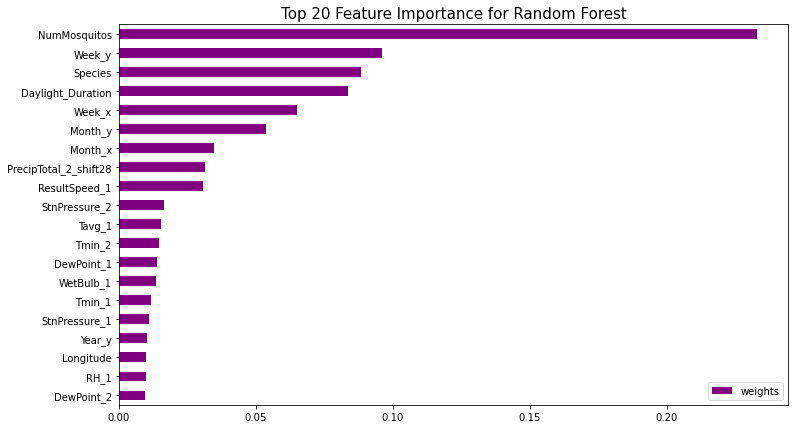

In [49]:
# Plotting Top 20 features in bar chart
imp_rf.head(20).plot(kind='barh', label=imp_rf.columns[:20], figsize=(12,7), color='purple')
plt.title('Top 20 Feature Importance for Random Forest', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

## Fitting ExtraTrees Classifier

In [51]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting Extra Trees')      

# Set up pipeline
et_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42))
    ])

# Hyperparameters
et_params = {
    'et__n_estimators': [80, 100, 120],
    'et__max_depth': [3, 5],
    'et__min_samples_leaf': [2, 4],
    'et__min_samples_split' : [2, 4]
}

# Instantiate 5-fold GridSearchCV.
gs_et = GridSearchCV(et_pipe, param_grid = et_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_et.fit(Xs_train, y_train)
gs_et_model = gs_et.best_estimator_

# See results
print(f'The best parameters are {gs_et.best_estimator_}.')

Fitting Extra Trees
Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('et',
                 ExtraTreesClassifier(max_depth=5, min_samples_leaf=2,
                                      random_state=42))]).
CPU times: user 911 ms, sys: 110 ms, total: 1.02 s
Wall time: 20.8 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [52]:
et = ExtraTreesClassifier(max_depth=5, min_samples_leaf=2,
                     random_state=42)
et.fit(Xsm_train, ysm_train)

ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, random_state=42)

In [53]:
et.score(Xsm_train,ysm_train)

0.8018650088809947

In [54]:
# Append to the lists
model_name.append('ExtraTrees')
model_scores.append(et.score(Xsm_train, ysm_train))
model_var.append(et)
model_test_scores.append(et.score(Xs_test,y_test))

### Evaluating ExtraTrees Results

In [55]:
imp_et = pd.DataFrame(et.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

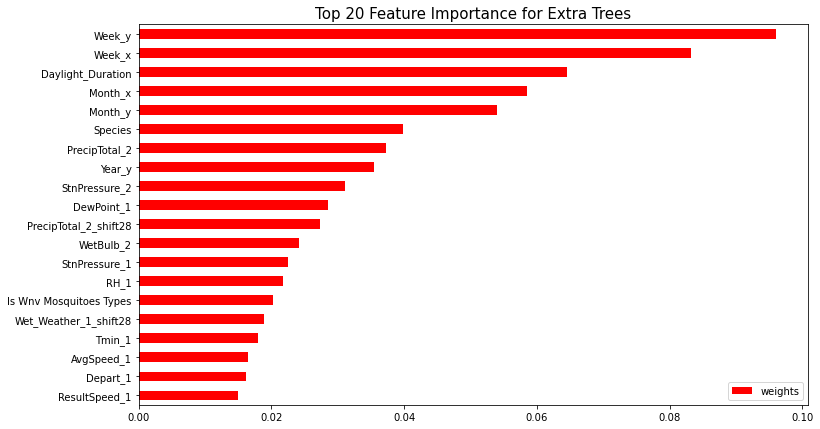

In [56]:
# Top 20 features
imp_et.head(20).plot(kind='barh', label=imp_et.columns, figsize=(12,7), color='red')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

### Fitting AdaBoost Classifier

In [57]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting AdaBoost')     

# Set up pipeline
ada_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('ada', AdaBoostClassifier(random_state=42))
    ])

# Hyperparameters
ada_params = {
    'ada__n_estimators': [20, 30, 40, 50],
    'ada__learning_rate': [0.8, 0.9, 1]
}

# Instantiate 5-fold GridSearchCV.
gs_ada = GridSearchCV(ada_pipe, param_grid = ada_params, cv=5,
                      scoring='roc_auc', n_jobs=-1,
                     verbose=1)

# Fit
gs_ada.fit(Xs_train, y_train)
gs_ada_model = gs_ada.best_estimator_

# See results
print(f'The best parameters are {gs_ada.best_estimator_}.')

Fitting AdaBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.9, random_state=42))]).
CPU times: user 1.18 s, sys: 34.9 ms, total: 1.21 s
Wall time: 14.7 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [58]:
ada = AdaBoostClassifier(learning_rate=0.9, random_state=42)
ada.fit(Xsm_train, ysm_train)

AdaBoostClassifier(learning_rate=0.9, random_state=42)

In [59]:
ada.score(Xsm_train,ysm_train)

0.9023978685612789

In [60]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(ada.score(Xsm_train, ysm_train))
model_var.append(ada)
model_test_scores.append(ada.score(Xs_test,y_test))

### Evaluating AdaBoost Results

In [61]:
imp_ada = pd.DataFrame(ada.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

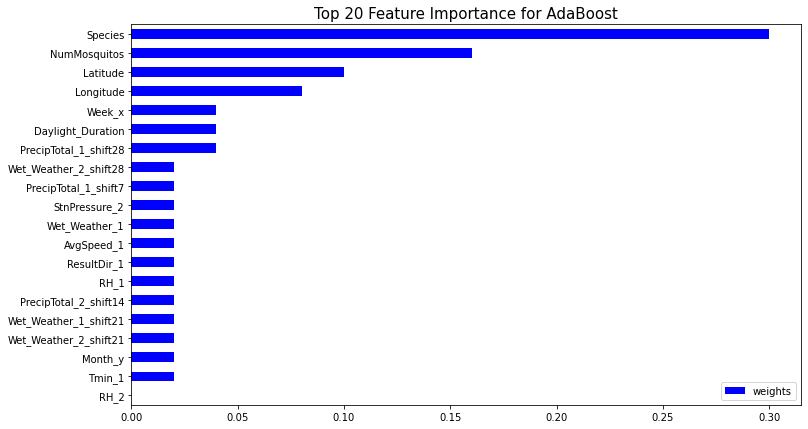

In [62]:
# Plot in bar chart
imp_ada.head(20).plot(kind='barh', label=imp_ada.columns[:20], figsize=(12,7), color='blue')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

### Fitting Gradient Boost Classifier

In [63]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting Gradient Boost')     

# Set up pipeline
gboost_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('gboost', GradientBoostingClassifier())
    ])

# Hyperparameters
gboost_params = {
    'gboost__n_estimators': [80, 100, 120, 150],
    'gboost__max_depth': [1, 2, 3],
    'gboost__min_samples_split': [2, 4],
    'gboost__min_samples_leaf': [1, 2]
}

# Instantiate 5-fold GridSearchCV.
gs_gboost = GridSearchCV(gboost_pipe, param_grid = gboost_params, cv=5,
                         scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_gboost.fit(Xs_train, y_train)
gs_gboost_model = gs_ada.best_estimator_

# See results
print(f'The best parameters are {gs_gboost.best_estimator_}.')

Fitting Gradient Boost
Fitting 5 folds for each of 48 candidates, totalling 240 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('gboost',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=80))]).
CPU times: user 3.52 s, sys: 88.4 ms, total: 3.6 s
Wall time: 4min 13s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [64]:
gboost = GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=4, n_estimators=80)
gboost.fit(Xsm_train, ysm_train)

GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=4,
                           n_estimators=80)

In [65]:
gboost.score(Xsm_train,ysm_train)

0.9278863232682061

In [66]:
# Append to the lists
model_name.append('GradientBooast')
model_scores.append(gboost.score(Xsm_train, ysm_train))
model_var.append(gboost)
model_test_scores.append(gboost.score(Xs_test,y_test)) 

In [67]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

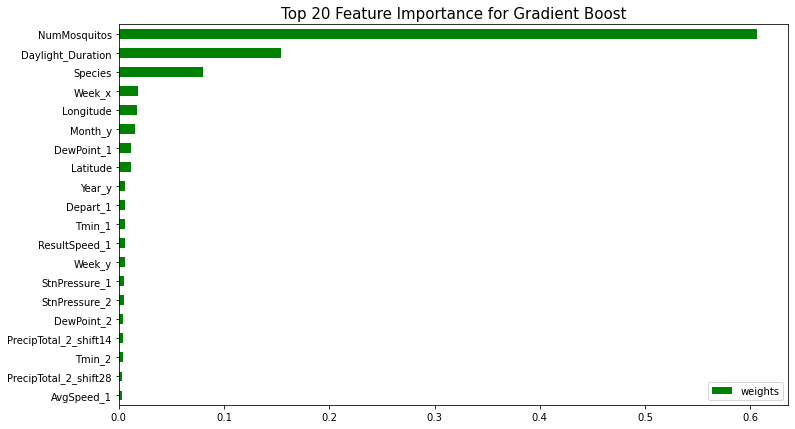

In [68]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

### Combining results together

In [69]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest F1-Score
precision_list = []
recall_list = []
fscore_list = []
auc_list_train = []
auc_list_test = []
for model in model_var:
    y_pred = model.predict(Xs_test)
    y_pred_train = model.predict(Xs_train)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    auc_list_train.append(roc_auc_score(y_train, y_pred_train))
    auc_list_test.append(roc_auc_score(y_test, y_pred))

pd.DataFrame({'Model Type': model_name,
              'Train AUC': auc_list_train,
              'Test AUC': auc_list_test,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores})

,Model Type,Train AUC,Test AUC,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy
0,Logistic Regression,0.822426,0.804288,0.596738,0.804288,0.591278,0.840675,0.790247
1,Naive Bayes,0.721080,0.706560,0.520258,0.706560,0.553142,0.720693,0.705411
2,Random Forest,0.823978,0.788919,0.600008,0.788919,0.590728,0.872824,0.800935
3,ExtraTrees,0.783513,0.762194,0.519981,0.762194,0.563578,0.801865,0.681363
4,AdaBoost,0.831723,0.792789,0.647540,0.792789,0.616944,0.902398,0.857715
5,GradientBooast,0.846093,0.783812,0.667459,0.783812,0.631591,0.927886,0.880428
